In [38]:
from os.path import join, dirname
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines
from matplotlib.patches import Rectangle

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import openpyxl
import pingouin as pg

In [35]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
img_bg = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

In [5]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55', '71', '72', '73', '74'
    , '75'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [6]:
## Do not change it!
list_label=[
    'rest',
    'RaPU', 'LaPU', 'LpPU', 'RpPU',
    'LaCA', 'LpCA', 'RaCA', 'RpCA'
]
list_roi=[
    'LaCA', 'RaCA', 'LpCA', 'RpCA',
    'LaPU', 'RaPU', 'LpPU', 'RpPU'
]

In [7]:
list_run = ['r%02d'%(rr+1) for rr in range(3)]
list_group = ['no_stim','DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']

In [8]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [9]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [10]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [11]:
dz = pd.concat([dx, dy])
del dx, dy
dz

,group
GA01,no_stim
GA35,no_stim
GA26,no_stim
GA02,no_stim
GA18,no_stim
...,...
GP71,DLPFC_20Hz
GP72,DLPFC_20Hz
GP73,DLPFC_20Hz
GP74,DLPFC_20Hz


---

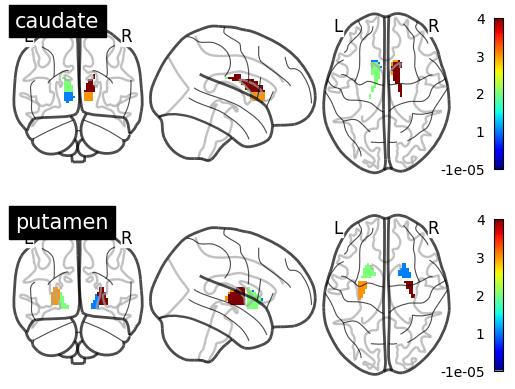

In [13]:
fig, axs = plt.subplots(nrows=2)

imgs = {}
for ii, roi in enumerate(['caudate','putamen']):
    ax = axs[ii]
    imgs[roi] = image.load_img(
        join(dir_mask,'mask.TTatlas.%s.resampled.nii'%roi),
    )
    plotting.plot_glass_brain(
        imgs[roi],
        title=roi,
        cmap=cm.jet, colorbar=True,
        axes=ax
    )

putamen: ra=1, la=2, lp=3, rp=4 \
caudate: la=1, lp=2, ra=3, rp=4

---

# 1. Fig. S1A

In [14]:
img_mask = image.math_img(
    img1=imgs['putamen'], img2=imgs['caudate'],
    formula='img1 + (img2+4)*(img2>0)'
)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



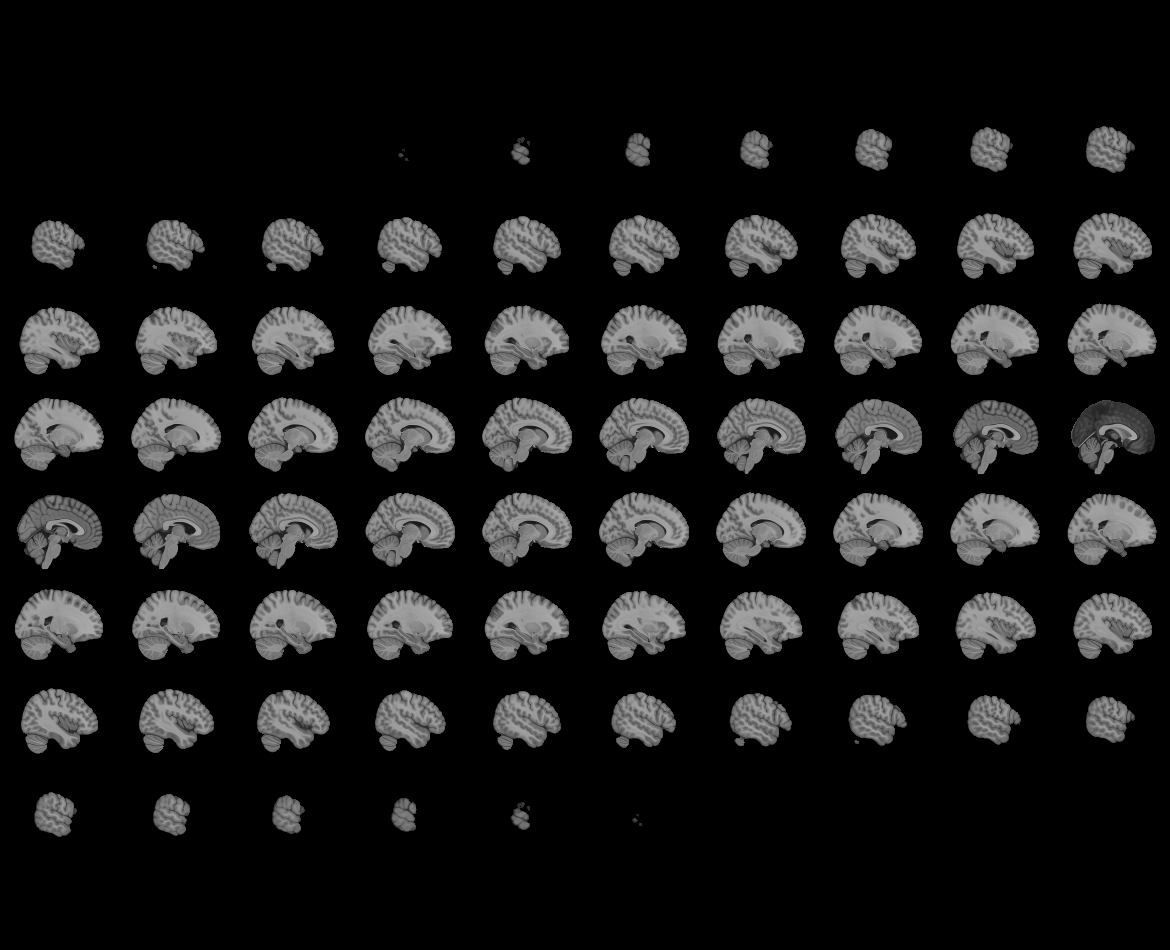
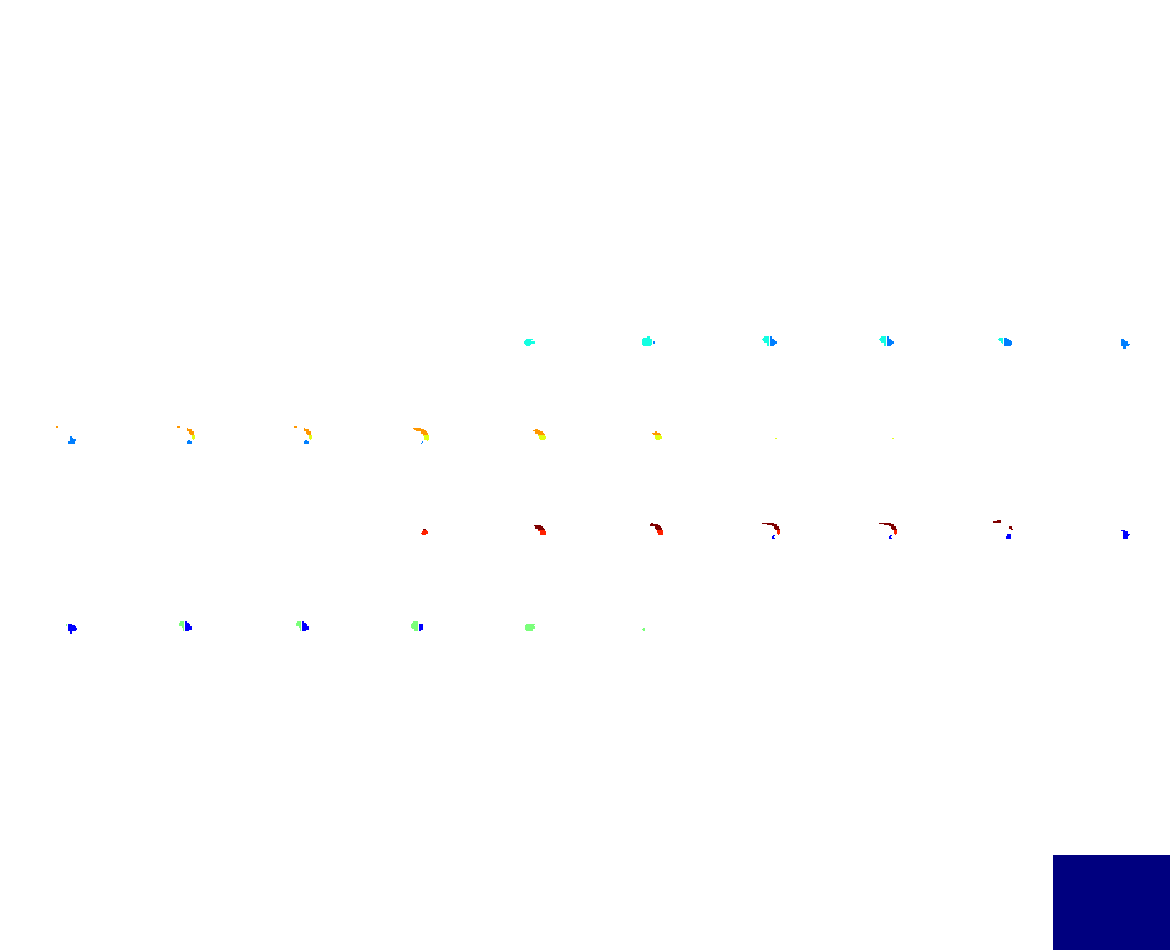

In [15]:
plotting.view_img(
    img_mask,
    cmap=cm.jet.resampled(9), colorbar=True, symmetric_cmap=False,
    resampling_interpolation='nearest'
)

In [16]:
changed_idx = []
tmp = list_label[1:]
for i in range(8):
    if tmp[i] != list_roi[i]:
        changed_idx.append((i,list_roi.index(tmp[i])))
changed_idx

[(0, 5), (1, 4), (2, 6), (3, 7), (4, 0), (5, 2), (6, 1), (7, 3)]

In [17]:
palette = sns.color_palette("hls", len(list_roi))
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

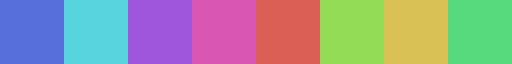

In [18]:
tmp = []
for (i,j) in changed_idx:
    tmp.append(palette[j])
palette = sns.color_palette(tmp)
cmap = colors.ListedColormap(palette)
cmap

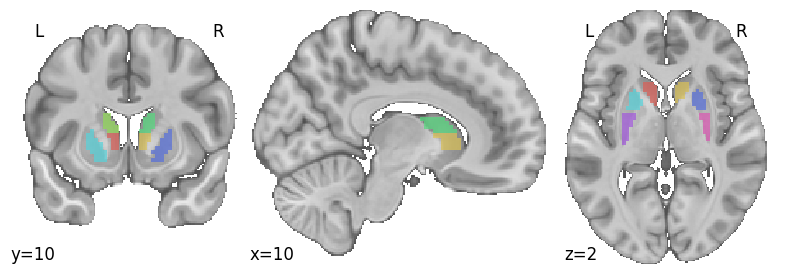

In [19]:
fig, ax = plt.subplots(figsize=(10, 3.3)) 

plotting.plot_roi(
    img_mask, black_bg=False,
    bg_img=img_bg,
    display_mode='ortho', draw_cross=False,
    cut_coords=(10, 10, 2),  # Adjust these coordinates based on your needs
    # view_type='contours', linewidths=2.5,
    cmap=cmap,
    axes = ax
)

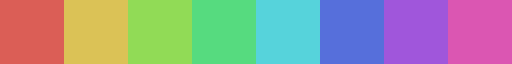

In [20]:
palette = sns.color_palette("hls", len(list_roi))
cmap = colors.ListedColormap(palette)
cmap

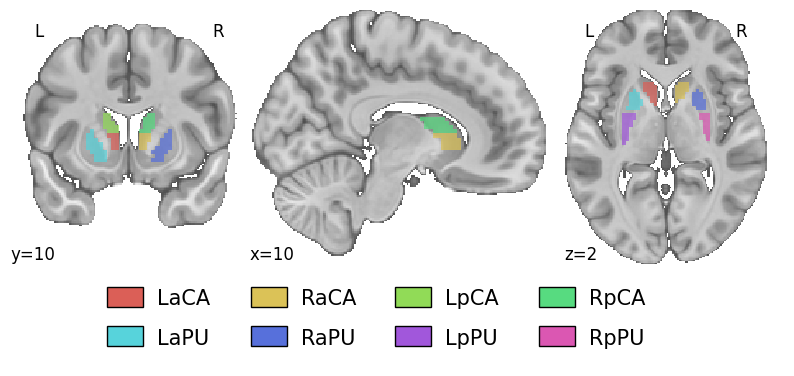

In [21]:
### legend
nax = fig.add_axes([0.15, -0.2, 0.72, 0.3])

# list_color = np.round(np.linspace(0, cmap.N-1, 4)).astype(int)

for ii, roi in enumerate(list_roi):
        
    rgb = cmap(ii)
    dx = 0.2
    dy = 0.4
    x, y = 0.1 + dx*(ii%4), 0.6 - dy*(ii//4)
    w, h = 0.05, 0.2
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.07, y-0.02, roi, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig

In [22]:
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GP/results/fig.S1a.png'
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---

In [22]:
dict_nvoxels = {}
tmp = img_mask.get_fdata().astype(int)
for ii, l in enumerate(list_label):
    dict_nvoxels[l] = len(tmp[tmp==ii])
dict_nvoxels

{'rest': 544614,
 'RaPU': 135,
 'LaPU': 133,
 'LpPU': 132,
 'RpPU': 105,
 'LaCA': 71,
 'LpCA': 103,
 'RaCA': 66,
 'RpCA': 109}

In [23]:
masker = NiftiLabelsMasker(
    labels_img=img_mask, labels=list_label,
    memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
)

---

## Calculate $\beta s$ in each ROI

In [24]:
prop = 'Rew#1_Coef'

In [25]:
df = pd.DataFrame()

for run in list_run:
    print(run)
    
    ## GA
    a = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
            , 'GA??/%s.%s.GA??.nii'%(prop,run)
        )))
    ## GP
    p = sorted(glob(join(dir_stat,'GP??/%s.%s.GP??.nii'%(prop,run))))
    
    ## combining these as whole data set
    list_fname = np.concatenate([a,p])

    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']

#         beta = masking.apply_mask(imgs=fname, mask_img=img)
        betas = masker.fit_transform(fname)[0]
        for ii, roi in enumerate(list_label[1:]):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'run':run,
                    'roi':roi,
#                     'lr':roi[0], 'ap':roi[1], 'anat':roi[2:],
                    'beta':betas[ii],
                    'nvoxels':dict_nvoxels[roi]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
# df.set_index('subj', inplace=True)
# df.index.name = None

r01


100%|██████████| 80/80 [00:01<00:00, 48.78it/s]


r02


100%|██████████| 80/80 [00:01<00:00, 49.29it/s]


r03


100%|██████████| 80/80 [00:01<00:00, 49.11it/s]


In [26]:
df = df.astype({'beta':float, 'nvoxels':int})
# df['beta_sum'] = df.beta*df.nvoxels
df

,subj,group,run,roi,beta,nvoxels
0,GA01,no_stim,r01,RaPU,0.518611,135
1,GA01,no_stim,r01,LaPU,0.599993,133
2,GA01,no_stim,r01,LpPU,0.151185,132
3,GA01,no_stim,r01,RpPU,0.272298,105
4,GA01,no_stim,r01,LaCA,0.538827,71
...,...,...,...,...,...,...
1915,GP75,DLPFC_20Hz,r03,RpPU,0.614432,105
1916,GP75,DLPFC_20Hz,r03,LaCA,0.917109,71
1917,GP75,DLPFC_20Hz,r03,LpCA,0.538714,103
1918,GP75,DLPFC_20Hz,r03,RaCA,1.086447,66


In [27]:
# df.to_excel('/home/sungbeenpark/Github/labs/GP/results/performance_modulated_activity.8_striatum.xlsx', index=False)

In [37]:
df.to_excel('/home/sungbeenpark/Github/labs/GP/results/Rew#1_Coef.xlsx', index=False)

---

# Fig. S2

## Two-way ANOVA

1. r01

In [45]:
result_anova = pg.anova(
    data=df[df.run=='r01'],
    dv='beta', between=['group','roi'],
    detailed=True, effsize="np2"
)
print(result_anova)

        Source         SS     DF        MS          F         p-unc       np2
0        group   0.674481    3.0  0.224827   2.556875  5.433738e-02  0.012459
1          roi   8.803347    7.0  1.257621  14.302456  2.912651e-17  0.141385
2  group * roi   0.452382   21.0  0.021542   0.244989  9.998167e-01  0.008391
3     Residual  53.461696  608.0  0.087930        NaN           NaN       NaN


2. r03

In [39]:
result_anova = pg.anova(
    data=df[df.run=='r03'],
    dv='beta', between=['group','roi'],
    detailed=True, effsize="np2"
)
print(result_anova)

        Source         SS     DF        MS          F         p-unc       np2
0        group   4.308334    3.0  1.436111  12.434067  6.687697e-08  0.057806
1          roi   7.734266    7.0  1.104895   9.566348  2.636782e-11  0.099212
2  group * roi   1.022659   21.0  0.048698   0.421635  9.897750e-01  0.014354
3     Residual  70.222857  608.0  0.115498        NaN           NaN       NaN


## Plot (with T-test)

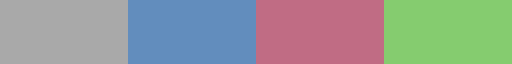

In [40]:
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
# palette = ['#A9A9A9', '#628dbd', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

In [41]:
hue_order = ['no_stim','DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']
# hue_order = ['no_stim','DLPFC_cTBS','DLPFC_20Hz']

# n_Bonferroni = len(list_roi)*len(list_run)*len(hue_order)
n_Bonferroni = len(list_roi)*2 # 2 means 'no_stim vs. DLPFC_cTBS' or 'no_stim vs. DLPFC_20Hz'
n_Bonferroni

16

LaCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.072 (*p=0.04401 uncorrected / nsp=0.70414 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.273 (*p=0.02988 uncorrected / nsp=0.47803 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.348 (*p=0.02546 uncorrected / nsp=0.40731 corrected)

RaCA
r01
r02
DLPFC_cTBS vs M1_cTBS : t(32)=-2.278 (*p=0.02955 uncorrected / nsp=0.47277 corrected)
r03
no_stim vs DLPFC_cTBS : t(45)=2.320 (*p=0.02495 uncorrected / nsp=0.39916 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.385 (*p=0.02317 uncorrected / nsp=0.37072 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.334 (*p=0.02625 uncorrected / nsp=0.42004 corrected)

LpCA
r01
r02
r03
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.608 (*p=0.01389 uncorrected / nsp=0.22228 corrected)

RpCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.043 (*p=0.04694 uncorrected / nsp=0.75107 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.097 (*p=0.04397 uncorrected / nsp=0.70346 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-3.177 (**p=0.00336 uncorrecte

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

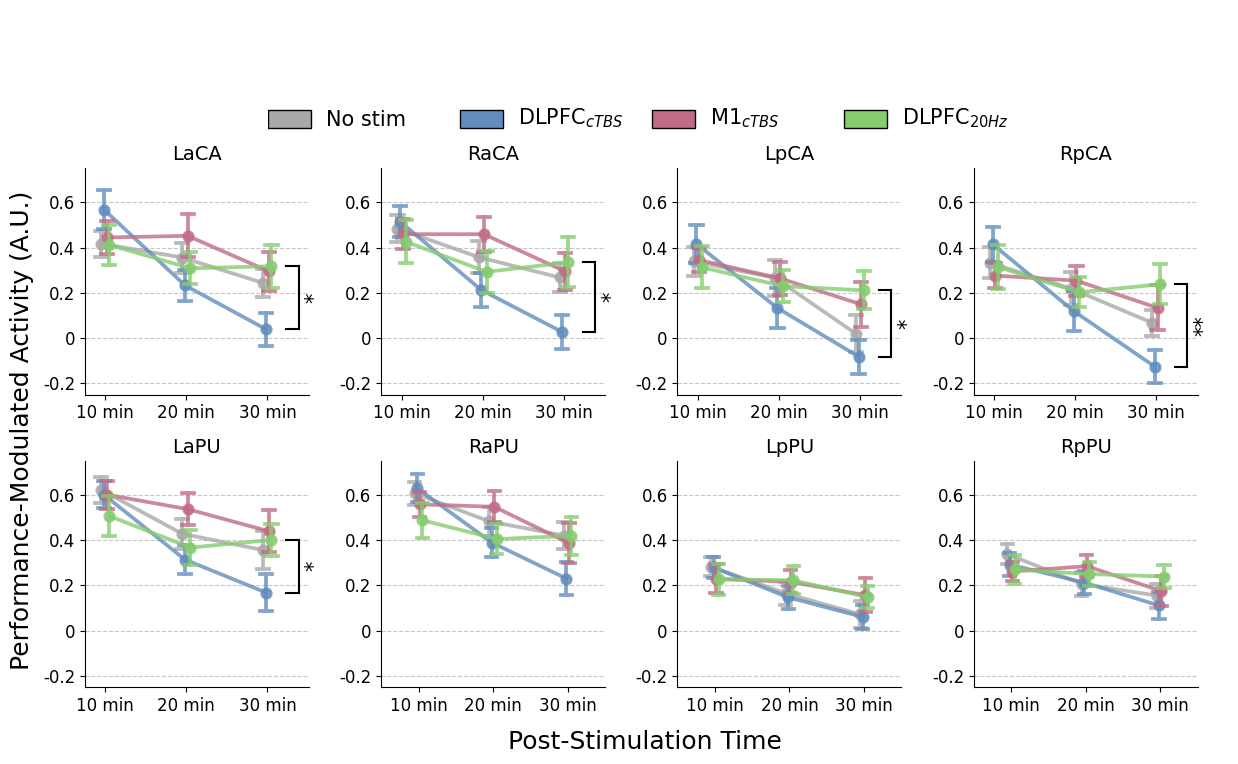

In [46]:
ncols, nrows = 4, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=list_run, hue_order=hue_order, palette=palette[:len(hue_order)],
        errorbar='se', capsize=0.15,
        dodge=True, alpha=0.8,
        ax=ax
    )
    ax.set_title(roi, fontsize=14, loc='center')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().remove()
    
    ax.set_ylim(-0.25,0.75)
    ax.set_ylabel('', fontsize=0)
    ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6], fontsize=12)
    
    ax.set_xlabel('', fontsize=0)
    ax.set_xticks(list_run)
    ax.set_xticklabels(['10 min', '20 min', '30 min'], fontsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    print(roi)
    for kk, run in enumerate(list_run):
        print(run)
        for ii, g1 in enumerate(hue_order):
            for jj, g2 in enumerate(hue_order[ii+1:]):
                a = df[(df.group==g1)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                b = df[(df.group==g2)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                res = stats.ttest_ind(a,b)
                tval, pval = res
                dof = res.df
                ## Bonferroni correction
                pval_c = pval * n_Bonferroni

                if pval < 0.05:
                    print('%s vs %s : t(%d)=%.3f (%sp=%.5f uncorrected / %sp=%.5f corrected)'%
                        (g1,g2,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
                    )
                    # if g1 == 'DLPFC_cTBS' and g2 == 'no_stim':
                    if g1 == 'DLPFC_cTBS' and g2 == 'DLPFC_20Hz':
                        x1 = kk + 0.035 + 0.2
                        x2 = x1 + 0.15
                        y1 = a.mean()
                        y2 = b.mean()
                        g.plot([x1, x2], [y1, y1], 'k-')
                        g.plot([x1, x2], [y2, y2], 'k-')
                        g.plot([x2, x2], [y1, y2], 'k-')
                        g.text(
                            x2+0.2, (y1+y2)*0.5, convert_pvalue_to_asterisks(pval),
                            ha='center', va='center', rotation=90, size=15,
                            color='k'
                        )
    print('')

fig.text(-.015, 0.5, 'Performance-Modulated Activity (A.U.)', va='center', rotation='vertical', fontsize=18)
fig.text(0.4, -0.02, 'Post-Stimulation Time', va='center', rotation='horizontal', fontsize=18)

fig.tight_layout()

## legend
nax = fig.add_axes([0.20, 1, .8, 0.2])
list_color = np.round(np.linspace(0, cmap.N-1, 3)).astype(int)
for ii, group in enumerate(hue_order):
    if group == 'no_stim':
        gg = 'No stim'
    elif group == 'DLPFC_cTBS':
        gg = 'DLPFC$_{cTBS}$'
    elif group == 'M1_cTBS':
        gg = 'M1$_{cTBS}$'
    elif group == 'DLPFC_20Hz':
        gg = 'DLPFC$_{20Hz}$'
        
    rgb = cmap(ii)
    dx = 0.2*ii
    # dx = 0.25*ii
    x, y = 0 + dx, 0.02
    w, h = 0.045, 0.15
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.06, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    # nax.text(x+.085, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')    
nax.axis('off')

In [47]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.S2.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---